# DNA Motif Detection — CNN Demo

**Biological framing:** Promoters often contain short motifs (e.g. a TATA box). We want to predict **promoter vs non-promoter** from sequence alone.

To keep this demo reproducible, we generate synthetic sequences:
- **Positive**: contains motif `TATA`
- **Negative**: random DNA

### Pipeline
1. DNA strings → one-hot tensor (length × 4)
2. Model: small 1D CNN
3. Evaluation: accuracy + loss curve
4. Insight: convolution filters behave like motif detectors

Runtime target: **< 30 seconds**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [3]:
# 1. Generate synthetic DNA sequences

ALPHABET = np.array(list("ATCG"))
MOTIF = "TATA"
SEQ_LEN = 80


def random_dna(n, length=SEQ_LEN):
    return ["".join(rng.choice(ALPHABET, size=length)) for _ in range(n)]


def insert_motif(seq, motif=MOTIF):
    # Insert motif at a random position
    pos = rng.integers(0, len(seq) - len(motif) + 1)
    return seq[:pos] + motif + seq[pos + len(motif) :]


def make_dataset(n_pos=600, n_neg=600):
    neg = random_dna(n_neg)
    pos = [insert_motif(s) for s in random_dna(n_pos)]
    X = pos + neg
    y = np.array([1] * n_pos + [0] * n_neg, dtype=np.int64)

    # Shuffle
    idx = rng.permutation(len(X))
    X = [X[i] for i in idx]
    y = y[idx]
    return X, y


seqs, labels = make_dataset()
print("Example positive contains motif?", MOTIF in seqs[np.argmax(labels)])
print("Example negative contains motif?", MOTIF in seqs[np.argmin(labels)])
print("Total:", len(seqs), "Pos rate:", labels.mean().round(3))

Example positive contains motif? True
Example negative contains motif? True
Total: 1200 Pos rate: 0.5


In [4]:
# 2. DNA → one-hot tensor (length × 4)

BASE_TO_IDX = {"A": 0, "T": 1, "C": 2, "G": 3}


def one_hot_encode(seq):
    x = np.zeros((len(seq), 4), dtype=np.float32)
    for i, ch in enumerate(seq):
        x[i, BASE_TO_IDX[ch]] = 1.0
    return x


class DNADataset(Dataset):
    def __init__(self, seqs, labels):
        self.X = np.stack([one_hot_encode(s) for s in seqs])  # (N, L, 4)
        self.y = labels.astype(np.float32)  # BCE expects float targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # For Conv1d we want (channels, length)
        x = torch.from_numpy(self.X[idx]).transpose(0, 1)  # (4, L)
        y = torch.tensor(self.y[idx])
        return x, y


# quick sanity check
d = DNADataset(seqs[:3], labels[:3])
print(d[0][0].shape, d[0][1].item())

torch.Size([4, 80]) 1.0


In [5]:
# 3. Train/test split + loaders

n = len(seqs)
split = int(0.8 * n)
train_seqs, test_seqs = seqs[:split], seqs[split:]
train_y, test_y = labels[:split], labels[split:]

train_ds = DNADataset(train_seqs, train_y)
test_ds = DNADataset(test_seqs, test_y)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))

Train batches: 15 Test batches: 2


In [6]:
# 4. Small 1D CNN model

class MotifCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=16, kernel_size=8, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8, padding=0),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(1)  # logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MotifCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Device:", device)
print(model)

Device: cpu
MotifCNN(
  (net): Sequential(
    (0): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(8,), stride=(1,))
    (4): ReLU()
    (5): AdaptiveMaxPool1d(output_size=1)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [7]:
# 5. Training loop (few epochs)

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds == yb.long()).sum().item()
            total += xb.size(0)
    return total_loss / total, correct / total


train_losses = []
test_losses = []
test_accs = []

EPOCHS = 5
for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

        running += loss.item() * xb.size(0)

    train_loss = running / len(train_ds)
    test_loss, test_acc = evaluate(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch}/{EPOCHS} - train_loss={train_loss:.4f} test_loss={test_loss:.4f} test_acc={test_acc:.3f}")

Epoch 1/5 - train_loss=0.6934 test_loss=0.6911 test_acc=0.496
Epoch 2/5 - train_loss=0.6887 test_loss=0.6879 test_acc=0.625
Epoch 3/5 - train_loss=0.6842 test_loss=0.6848 test_acc=0.642
Epoch 4/5 - train_loss=0.6787 test_loss=0.6801 test_acc=0.600
Epoch 5/5 - train_loss=0.6711 test_loss=0.6719 test_acc=0.671


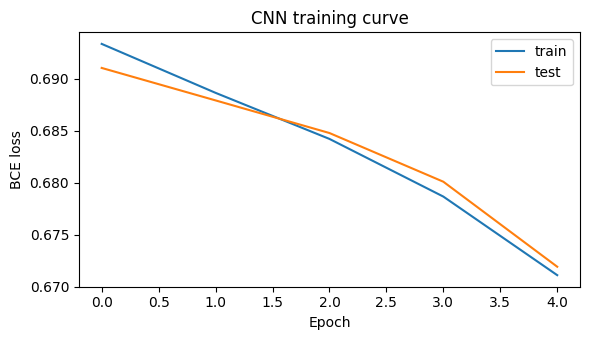

Final test accuracy: 0.671


In [8]:
# 6. Plot loss curve

plt.figure(figsize=(6, 3.5))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.title("CNN training curve")
plt.legend()
plt.tight_layout()
plt.show()

print("Final test accuracy:", round(test_accs[-1], 3))

## What to say during the live demo

- “We’re not using hand-crafted features — the model learns patterns directly from sequence.”
- “The **convolution filters** slide across DNA and become **motif detectors**.”
- “Because positives always contain `TATA`, a small CNN can learn that quickly.”

## How to extend
- Replace synthetic sequences with a real promoter/non-promoter dataset (FASTA) in `data/`.
- Add multiple motifs and make it multi-label.
- Add attention or a transformer encoder for longer contexts.